In [1]:
# 2020.02.18 to 2020.02.27
#   v.01  2020.02.21
#   v.02  2020.02.26
# data analysis for ground anchors
# for ASTRA Thun

# description of anchor data analysis task

1) locate the authoritative data -> spreadsheets <br />
2) define the header for anchor measurement records (field names) <br />
3) link the spreadsheet data into the csv sheet format (following header) <br />
4) acquire the spreadsheet CSV data with Pandas (with basic data checking) <br />
5) set up agreed data analysis procedures -> will be limited in this phase <br />
6) set up interactive plotting for exploring anchor data (as protype) <br />
7) produce agreed plots for initial presentation purposes <br />

Based on initial data review, new spreadsheets with corrected and more complete data were provided. Task 3) was therefore repeated.

# to do
* rename 'anchor_load_char' to 'anchor_failure_load_char'
* accept anchor_id as str or number in csv and convert pandas column format to str  
  (see fix below for plots of load history of individual anchors)

# setup

In [2]:
# setup for python ecosystem
import json
from math import *
import glob
import pandas as pd
import numpy as np
from IPython.core.display import HTML, display
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import norm
from scipy.stats import lognorm
from scipy import stats

In [3]:
# setup for pandas
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns',100)

In [4]:
# setup for pixiedust data exploration
import pixiedust
from pixiedust.display import *
# installed:
# sudo pip install --user --upgrade pixiedust 
# sudo pip install seaborn
# sudo pip install bokeh

# "Bad 'legend' parameter value: None" when plotting bokeh with pixiedust
# https://github.com/org-arl/arlpy/issues/31 
# appears to be bug with bokeh, fix is to degrade the version of Bokeh 1.3
# sudo pip install bokeh==1.3.0

Pixiedust database opened successfully


In [5]:
# define common functions

# function for calculating allowable anchor force
# based on SIA 260 (2013) 
# as documented in https://docs.google.com/spreadsheets/d/17GsuXH_9kubzu-f16cIugCzPtyKBbbA4Jdm00d-uyHU/edit#gid=469557799
#   steel_xsect_area = total steel cross-section, e.g. of steel tendon strands (mm)
#   steel_tensile_strength_char = characteristic tensile strength of anchor steel (N/mm2 = MPa)
#   anchor_load_char = anchor load when characteristic tensile strength of anchor steel is reached (kN)
def anchor_load_char_calc_sia260(steel_xsect_area, steel_tensile_strength_char):
    anchor_load_char = steel_xsect_area * steel_tensile_strength_char /1000.0
    return(anchor_load_char)

# function for determining capacity utilization of an anchor
# based on ASTRA "Risikoanalyse"  
# as documented in https://docs.google.com/spreadsheets/d/17GsuXH_9kubzu-f16cIugCzPtyKBbbA4Jdm00d-uyHU/edit#gid=4695577997
#   measured_anchor_load = measured anchor load during monitoring (kN)
#   measurement_tol = measurement tolerance (%)
#   anchor_capacity_utiliz = pro cent capacity utilization of an anchor (fraction between 0 and 1)
def anchor_capacity_utiliz_calc_astra(measured_anchor_load, measurement_tol, anchor_load_char):
    anchor_capacity_utiliz = measured_anchor_load * (1-measurement_tol/100) / anchor_load_char
    return(anchor_capacity_utiliz) 

# function for calculating change in anchor load to installed anchor load 
# based on ASTRA "Risikoanalyse"  
#   installed_anchor_load = anchor load at time of anchor installation (kN)
#   anchor_load_change = measured anchor load minus installed anchor load (kN, positive value means increase load)
def anchor_load_change_calc_astra(measured_anchor_load, installed_anchor_load):
    anchor_load_change = measured_anchor_load - installed_anchor_load
    return(anchor_load_change)


# remarks on input data

* data sources
  * https://drive.google.com/drive/folders/1hg8eD9MrwUcdzMDHcKWOA0V6jrQybA9j
  * spreadshhets for five example structures
    * SM 4
    * SM 1 + B18
    * Felssicherung Chüebalm
    * Brücke Tuffgraben
    * SM 5


* the data in the sources cited above were taken by Tosacano AF 
  from various reports and drawings made available from ASTRA; <br /> 
  in this data analysis only data from the above five data sources are consdered


* data in data sources is partly conflicted in other documents
    * SM 4 in spreadsheet 'Untersuchung_Ankerkräfte_Risk  SM4' <br /> 
      https://docs.google.com/spreadsheets/d/17GsuXH_9kubzu-f16cIugCzPtyKBbbA4Jdm00d-uyHU/edit#gid=1364999228 <br /> 
      --> differences in steel area and steel strength


* each measurment is a data record, i.e. a spreadshet row in the CSV sheet; <br /> 
  having records for all measurements (years) in the same row is not good data practice and is not the data structure expected by dataframes (pandas) <br />
  [I suppose yearly data could be though of as a time series, but this seems like a convoluted way to work.]


* data from the spreadsheets was prepared by linking the original data in each spreadsheet to a CSV worksheet in the same worksheet, <br /> using common headers agreed specifically for this work, and then exporting the CSV worksheet


* structure_id and anchor_id
  * decimals (and spaces) in IDs are bad data practice


* the data from the intial anchor measurements (labelled P0 in the source spreadsheets) is enetered both as   installed_anchor_load and measured_anchor_load data; <br /> 
 this foresees that the two data sets may difer, e.g. installed_anchor_load may correspond to the intial prescribed load ("Festsetzkraft") and the measured_anchor_load may correspond to the actual installed anchor load (which may differ from the prescribe load if within a specified tolerance)


* the data entry sheet, the CSV sheet and the data column headers require additional review and refinement <br /> 
  before the collection and preparation of additional anchor data (see also remarks to data table design below)


# remarks to flat table from CSV sheet in spreadsheet:

* the CSV sheet for anchor data is configured as a single flat table <br />
  using a common header line with header titles for each data column
* the data structure suggests that two separate tables (anchor data table, measurment data table) should be used, <br />
  which would e.g. avoid the repetition of anchor data for each measurment record
* the anchor data table and measurment data table would then be joined in pandas into a single table
* a single flat table is used in this preliminary proof-of-concept work to simplify data preparation
* an appropriate data table design, e.g. using separate anchor data tables and measurment data tables <br /> 
  should be completed before additional input data is prepared
* a separate data entry sheet in the spreadsheet should be designed together with the data table design; <br /> 
  the purpose of the data entry sheet is to make data entry as easy and error free as possible, <br />
  with the CSV sheet being configured separately and structured for data analysis
  
  
* the first header line is intended for accessing data from python code and is in English using snake_case    
* a second header line is in German text and is intended to be used for figure and table titles
* additional header lines could be added for other languages


* additional data tables to consider are
  * structures table <br /> 
    using an appropriate structures id as a database key
  * anchor type table (?) <br /> 
    considering however that this will complicate data entry and whether anchor detail data is required

# data input

In [6]:
# read in csv files containign anchor data
anchors_df = pd.concat([pd.read_csv(f, header=[0,1], encoding='utf-8') for f in glob.glob('data/ASTRA/IN/*.csv')], 
                       ignore_index = True)

# remove second header line (for this work)
anchors_df.columns = anchors_df.columns.droplevel(-1)

#glob.glob('data/ASTRA/*.csv')  #testing
anchors_df.dtypes  #testing

inventory_id                            object
structure_name                          object
data_source                             object
structure_type                          object
anchor_id                               object
anchor_type                             object
steel_tensile_strength_char              int64
steel_xsect_area                         int64
anchor_load_char_calculation_method    float64
anchor_load_char                       float64
warning_value_calculation_method       float64
alarm_value_calculation_method         float64
warning_value                          float64
alarm_value                            float64
installation_date                        int64
installed_anchor_load                  float64
measurement_date                         int64
measured_anchor_load                   float64
stress_unit                             object
force_unit                              object
area_unit                               object
dtype: object

In [7]:
# configure date columns
#   dates in original data and csv data are year only
#   year date yyyy will be presumed as yyyy/01/01



# data analysis

In [8]:
# calculated fields
anchors_df["anchor_load_char"] = anchor_load_char_calc_sia260(anchors_df.steel_xsect_area, 
                                                anchors_df.steel_tensile_strength_char)

measurement_tol = 2.5  # %
anchors_df["anchor_capacity_utiliz"] = anchor_capacity_utiliz_calc_astra(anchors_df.measured_anchor_load, 
                                                measurement_tol, anchors_df.anchor_load_char)

anchors_df["anchor_load_change"] = anchor_load_change_calc_astra(anchors_df.measured_anchor_load, 
                                                anchors_df.installed_anchor_load)

# new fields for plotting
anchors_df["P"] = anchors_df.measured_anchor_load
anchors_df["P30"] = 0.3 * anchors_df.anchor_load_char
anchors_df["P70"] = 0.7 * anchors_df.anchor_load_char
anchors_df["anchor_structure"] = anchors_df.anchor_id +"_" +anchors_df.inventory_id  #anchor_id should be str for pixiedust
# anchor_id presently doubled-quoted in spreadsheet if number; better accept str or number and convert pandas column format to str

# testing

In [9]:
# data validity checking
#   test suite for testing data validity checking 
#   (e.g. string instead of float value, blank lines in csv data, garbled header title, ID fields NaN)

# how to introduce plausibility checking for measurement data?
#   simply omitting out-of-range values is not good, as anchors can conceivably fail e.g. leading to low measured values
#   maybe warning message and a function to manually delete a value, adding a comment to a new comment field?

# how to introduce plausibility checking for calculated data?
#   e.g if suspect capacity utilization in initial measurement


In [10]:
# function testing

steel_xsect_area = 1116  # mm2
steel_tensile_strength_char = 1770  # MPa
anchor_load_char = anchor_load_char_calc_sia260(steel_xsect_area, steel_tensile_strength_char)
print(anchor_load_char)

measured_anchor_load = 1100.0  #kN
measurement_tol = 2.5  # %
anchor_capacity_utiliz = anchor_capacity_utiliz_calc_astra(measured_anchor_load, measurement_tol, anchor_load_char)
print(anchor_capacity_utiliz)

installed_anchor_load = 1000.0
anchor_load_change = anchor_load_change_calc_astra(measured_anchor_load, installed_anchor_load)
print(anchor_load_change)

1975.32
0.542950003037
100.0


In [11]:
# data for end-to-end testing
#anchors_df[anchors_df.anchor_id.isin(['9a','9b'])]  #problems with pixiedust
#anchors_df[anchors_df.structure_id.isin(['SM4'])]  #problems with pixiedust

anchors_SM4 = anchors_df[anchors_df.data_source.isin(['SM4'])]
anchors_SM5 = anchors_df[anchors_df.data_source.isin(['SM5'])]
anchors_SM1 = anchors_df[anchors_df.data_source.isin(['SM1'])]
anchors_chuebalm = anchors_df[anchors_df.data_source.isin(['Felssicherung Chuebalm'])]
anchors_tuffgraben = anchors_df[anchors_df.data_source.isin(['Bruecke Tuffgraben'])]

In [12]:
# end-to-end testing
#anchors_tuffgraben[anchors_df['measurement_date']==2019].describe()
anchors_tuffgraben.describe()

#anchors_SM4[anchors_df['measurement_date']==2019].sum()

,steel_tensile_strength_char,steel_xsect_area,anchor_load_char_calculation_method,anchor_load_char,warning_value_calculation_method,alarm_value_calculation_method,warning_value,alarm_value,installation_date,installed_anchor_load,measurement_date,measured_anchor_load,anchor_capacity_utiliz,anchor_load_change,P,P30,P70
count,9.0,9.0,0.0,9.00,0.0,0.0,0.0,0.0,9.0,9.0,9.000000,9.000000,9.000000,9.000000,9.000000,9.000,9.000
mean,1770.0,1023.0,NaN,1810.71,NaN,NaN,NaN,NaN,1980.0,900.0,2003.000000,960.222222,0.517044,60.222222,960.222222,543.213,1267.497
std,0.0,0.0,NaN,0.00,NaN,NaN,NaN,NaN,0.0,0.0,17.684739,47.683272,0.025676,47.683272,47.683272,0.000,0.000
min,1770.0,1023.0,NaN,1810.71,NaN,NaN,NaN,NaN,1980.0,900.0,1980.000000,900.000000,0.484617,0.000000,900.000000,543.213,1267.497
25%,1770.0,1023.0,NaN,1810.71,NaN,NaN,NaN,NaN,1980.0,900.0,1980.000000,900.000000,0.484617,0.000000,900.000000,543.213,1267.497
50%,1770.0,1023.0,NaN,1810.71,NaN,NaN,NaN,NaN,1980.0,900.0,2010.000000,980.000000,0.527694,80.000000,980.000000,543.213,1267.497
75%,1770.0,1023.0,NaN,1810.71,NaN,NaN,NaN,NaN,1980.0,900.0,2019.000000,1004.000000,0.540617,104.000000,1004.000000,543.213,1267.497
max,1770.0,1023.0,NaN,1810.71,NaN,NaN,NaN,NaN,1980.0,900.0,2019.000000,1010.000000,0.543847,110.000000,1010.000000,543.213,1267.497


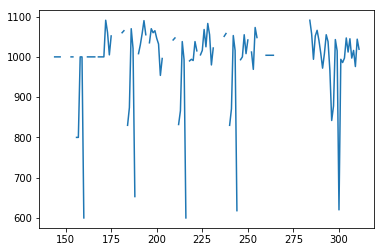

In [13]:
# check handling of NaN values by pandas plot -> NaN values are omitted in plot -> ok
# plot of anchor loads vs index    
#anchors_SM4.measured_anchor_load
anchors_SM4.measured_anchor_load.plot()

# dataframe views

In [14]:
anchors_df
#anchors_df[anchors_df['structure_id']=='SM4']
#anchors_df[anchors_df['anchor_id']=='18b']

,inventory_id,structure_name,data_source,structure_type,anchor_id,anchor_type,steel_tensile_strength_char,steel_xsect_area,anchor_load_char_calculation_method,anchor_load_char,warning_value_calculation_method,alarm_value_calculation_method,warning_value,alarm_value,installation_date,installed_anchor_load,measurement_date,measured_anchor_load,stress_unit,force_unit,area_unit,anchor_capacity_utiliz,anchor_load_change,P,P30,P70,anchor_structure
0,02.08.60.410.50,BRÜCKE SM Wäldli 1,SM1,Stützmauer,24.1a,VSL Typ EA35 5-12/12,1770,1116,NaN,1975.32,NaN,NaN,NaN,NaN,1983,1000.0,1983,1000.0,MPa,kN,mm,0.493591,0.0,1000.0,592.596,1382.724,24.1a_02.08.60.410.50
1,02.08.60.410.50,BRÜCKE SM Wäldli 1,SM1,Stützmauer,24.1b,VSL Typ EA35 5-12/12,1770,1116,NaN,1975.32,NaN,NaN,NaN,NaN,1983,1000.0,1983,1000.0,MPa,kN,mm,0.493591,0.0,1000.0,592.596,1382.724,24.1b_02.08.60.410.50
2,02.08.60.723.02,SM Wäldli 1 BR - SP,SM1,Stützmauer,20.a,VSL Typ EA35 5-12/12,1770,1116,NaN,1975.32,NaN,NaN,NaN,NaN,1983,1000.0,1983,1000.0,MPa,kN,mm,0.493591,0.0,1000.0,592.596,1382.724,20.a_02.08.60.723.02
3,02.08.60.723.02,SM Wäldli 1 BR - SP,SM1,Stützmauer,20.b,VSL Typ EA35 5-12/12,1770,1344,NaN,2378.88,NaN,NaN,NaN,NaN,1983,1000.0,1983,1000.0,MPa,kN,mm,0.409857,0.0,1000.0,713.664,1665.216,20.b_02.08.60.723.02
4,02.08.60.723.02,SM Wäldli 1 BR - SP,SM1,Stützmauer,19.a,VSL Typ EA35 5-12/12,1770,1116,NaN,1975.32,NaN,NaN,NaN,NaN,1983,1000.0,1983,1000.0,MPa,kN,mm,0.493591,0.0,1000.0,592.596,1382.724,19.a_02.08.60.723.02
5,02.08.60.723.02,SM Wäldli 1 BR - SP,SM1,Stützmauer,19.b,VSL Typ EA35 5-12/12,1770,1116,NaN,1975.32,NaN,NaN,NaN,NaN,1983,1000.0,1983,1000.0,MPa,kN,mm,0.493591,0.0,1000.0,592.596,1382.724,19.b_02.08.60.723.02
6,02.08.60.723.02,SM Wäldli 1 BR - SP,SM1,Stützmauer,18.a,VSL Typ EA35 5-12/12,1770,1116,NaN,1975.32,NaN,NaN,NaN,NaN,1983,1000.0,1983,1000.0,MPa,kN,mm,0.493591,0.0,1000.0,592.596,1382.724,18.a_02.08.60.723.02
7,02.08.60.723.02,SM Wäldli 1 BR - SP,SM1,Stützmauer,18.b,VSL Typ EA35 5-12/12,1770,1116,NaN,1975.32,NaN,NaN,NaN,NaN,1983,1000.0,1983,1000.0,MPa,kN,mm,0.493591,0.0,1000.0,592.596,1382.724,18.b_02.08.60.723.02
8,02.08.60.723.02,SM Wäldli 1 BR - SP,SM1,Stützmauer,17.a,VSL Typ EA35 5-12/12,1770,1116,NaN,1975.32,NaN,NaN,NaN,NaN,1983,1000.0,1983,1000.0,MPa,kN,mm,0.493591,0.0,1000.0,592.596,1382.724,17.a_02.08.60.723.02
9,02.08.60.723.02,SM Wäldli 1 BR - SP,SM1,Stützmauer,17.b,VSL Typ EA35 5-12/12,1770,1116,NaN,1975.32,NaN,NaN,NaN,NaN,1983,1000.0,1983,1000.0,MPa,kN,mm,0.493591,0.0,1000.0,592.596,1382.724,17.b_02.08.60.723.02


# data plots
### "... tell the (data) story"


### data overview

In [ ]:
# basic data check of all measured anchor loads
display(anchors_df)

# anchor 4B in SM5 for 1994 measurment appears invalid!  -> ok in revised v01 data


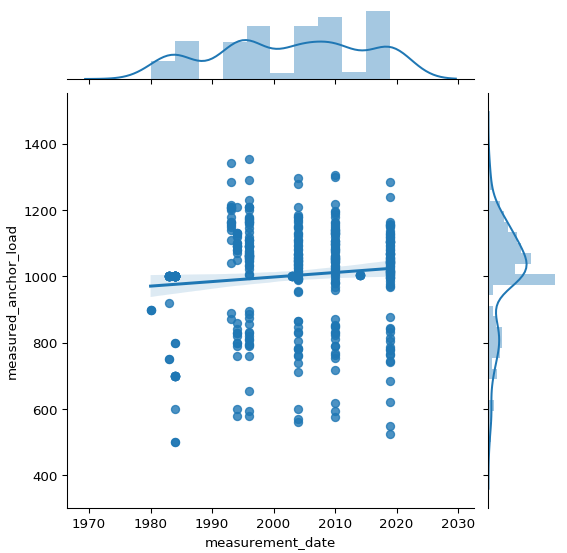

In [ ]:
# basic data check of all anchor measurements over time
display(anchors_df)

### data trends

In [ ]:
# scatterplot of anchor capacity utilization vs anchor load change
display(anchors_df)

# careful: anchor_id's are not unique !!
# anchor 18c at SMC4 has low capacity utilization, is data for calc_anchor_load correct ??

In [ ]:
# average of all anchors at each strcuture
display(anchors_df)

#display(anchors_df[anchors_df.structure_id.isin(['Bruecke Tuffgraben'])])
#display(anchors_SM4)

# are NaN values taken as zero??
# e.g. SM1 is not displayed correctly with 'display(anchors_df)', compare with 'display(anchors_SM1)'
#   -> looks more like a bug with pixiedust

### data for indiviudal anchors

In [ ]:
# anchor load over time for individual anchors
display(anchors_df[anchors_df['anchor_id']=='18b'])

# careful: anchor_id's are not unique !!
#          and 18.b and 18b give same result !!  -> seems to be strange pixiedust render updating behvaior
#            -> decimals (and spaces) in IDs are bad practice !!
# NaN values are omitted (expected behavior), but why different further below in subplots ??

/usr/local/lib/python2.7/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


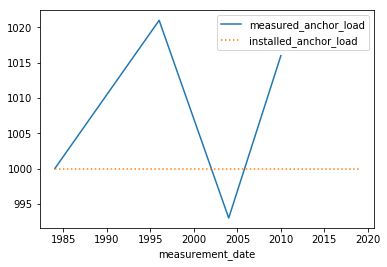

In [20]:

anchors_df[anchors_df['anchor_id']=='18b'].plot(x='measurement_date', 
                                                y=['measured_anchor_load','installed_anchor_load'], 
                                                style=['-',':'])


In [21]:
anchors_df["inventory_id"].unique()
#len(anchors_df["anchor_id"].unique())

array([u'02.08.60.410.50', u'02.08.60.723.02', u'02.08.60.410.51',
       u'02.08.60.410.63', u'02.08.60.714.12', u'02.08.60.723.08',
       u'02.08.60.410.55', u'02.08.60.723.07', u'02.08.60.410.54',
       u'02.08.60.723.06', u'02.08.60.410.53', u'02.08.60.723.05',
       u'02.08.60.410.52', u'02.08.60.723.04', u'02.08.60.723.09'],
      dtype=object)

In [22]:
# temp fix for dealing with limitation that Bokeh can only download 10 plots
#anchors_SM5["anchor_id"].unique()
anchors_SM1["anchor_id"].unique()

array([u'24.1a', u'24.1b', u'20.a', u'20.b', u'19.a', u'19.b', u'18.a',
       u'18.b', u'17.a', u'17.b', u'16.a', u'16.b', u'15.a', u'15.b',
       u'14.a', u'14.b', u'10.b', u'9.b', u'18.2'], dtype=object)

In [23]:
anchors_SM5_1 = anchors_SM5[anchors_SM5.anchor_id.isin([u'1A.u',u'1A.o',u'1B.u', u'1B.o', u'2A.u', u'2A.o', u'2B.u',u'2B.o', u'3A.u', u'3A.o'])]
anchors_SM5_2 = anchors_SM5[anchors_SM5.anchor_id.isin([u'3B.u', u'3B.o', u'4A', u'4B', u'5A',u'5B', u'6A', u'6B', u'7A.u', u'7A.o'])]
anchors_SM5_3 = anchors_SM5[anchors_SM5.anchor_id.isin([u'7B.u', u'7B.o', u'8A.u',u'8A.o', u'8B.u', u'8B.o', u'8C'])]

anchors_SM1_1 = anchors_SM1[anchors_SM1.anchor_id.isin([u'24.1a', u'24.1b', u'20.a', u'20.b', u'19.a', u'19.b', u'18.a', u'18.b', u'17.a', u'17.b'])]
anchors_SM1_2 = anchors_SM1[anchors_SM1.anchor_id.isin([u'16.a', u'16.b', u'15.a', u'15.b', u'14.a', u'14.b', u'10.b', u'9.b', u'18.2'])]

In [24]:
# fix string values in anchor_id (anchor_id's with quotes are not processed by Pixidust)
anchors_chuebalm_ = anchors_chuebalm.astype({"anchor_id": str})
anchors_chuebalm_["anchor_id"] = anchors_chuebalm_["anchor_id"].str.replace('"', '')
anchors_tuffgraben_ = anchors_tuffgraben.astype({"anchor_id": str})
anchors_tuffgraben_["anchor_id"] = anchors_tuffgraben_["anchor_id"].str.replace('"', '')

In [ ]:
# anchor load over time for all individual anchors at a structure
display(anchors_df)
#display(anchors_chuebalm_)
#display(anchors_tuffgraben_)

#display(anchors_df[anchors_df.structure_id.isin(['Bruecke Tuffgraben'])])

# NaN values taken as zero if Aggregation -> SUM used !!!
# NaN values omitted if Aggregation -> AVG used